### Data Prep

In [1]:
from alpaca.data.historical import StockHistoricalDataClient, CryptoHistoricalDataClient
from alpaca.data.requests import StockBarsRequest, CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime

from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv('API_KEY')
secret_key = os.getenv('SECRET_KEY')


start = datetime(2024, 1, 1)
end = datetime(2024, 12, 31)


# no keys required for etf data
etf_client = StockHistoricalDataClient(api_key=api_key, secret_key=secret_key)
crypto_client = CryptoHistoricalDataClient(api_key=api_key, secret_key=secret_key)

# Request parameters for etf IBIT
etf_request_params = StockBarsRequest(
                        symbol_or_symbols='IBIT',
                        timeframe=TimeFrame.Minute,
                        start=start,
                        end=end
                 )

# Request parameters for crypto BTC/USD
crypto_request_params = CryptoBarsRequest(
                        symbol_or_symbols='BTC/USD',
                        timeframe=TimeFrame.Minute,
                        start=start,
                        end=end
                 )

# Get etf and crypto bars
etf_bars = etf_client.get_stock_bars(etf_request_params)
crypto_bars = crypto_client.get_crypto_bars(crypto_request_params)

# Convert to dataframes
etf_df = etf_bars.df.reset_index()
crypto_df = crypto_bars.df.reset_index()

In [2]:
crypto_df = etf_client.get_stock_bars(StockBarsRequest(
                        symbol_or_symbols='BITB',
                        timeframe=TimeFrame.Minute,
                        start=start,
                        end=end
                 )).df.reset_index()

In [3]:
import numpy as np

df = etf_df.merge(crypto_df, on='timestamp', suffixes=['_etf', '_crypto'])

df['date'] = df['timestamp'].dt.date
df['log_close_crypto'] = np.log(df['close_crypto'])
df['log_close_etf'] = np.log(df['close_etf'])

In [4]:
df_day = df.groupby('date')

df[['LR_crypto', 'LR_etf']] = df_day\
    [['log_close_crypto', 'log_close_etf']]\
    .diff().T\
    .div(
        df_day['timestamp'].diff().dt.seconds / 60
    )\
    .T
    
df['vol_crypto'] = df['LR_crypto'].map(np.square)
df['vol_crypto_rr_10'] = df['vol_crypto'] / df_day['vol_crypto'].rolling(10).sum().map(np.sqrt).reset_index()['vol_crypto']
df['vol_crypto_rr_30'] = df['vol_crypto'] / df_day['vol_crypto'].rolling(30).sum().map(np.sqrt).reset_index()['vol_crypto']

df['trade_count_etf_diff'] = df_day['trade_count_etf'].diff()
df['log(trade_count_etf)'] = df['trade_count_etf'].map(np.log)

df['LR_crypto_rs_20'] = df_day['LR_crypto'].rolling(20).sum().reset_index()['LR_crypto']
df['LR_crypto_rs_10'] = df_day['LR_crypto'].rolling(10).sum().reset_index()['LR_crypto']
df['LR_crypto_rs_15'] = df_day['LR_crypto'].rolling(15).sum().reset_index()['LR_crypto']
df['LR_crypto_rs_5'] = df_day['LR_crypto'].rolling(5).sum().reset_index()['LR_crypto']


### Model: GLM w/ Log-Link 

In [5]:
data = df[['LR_crypto', 'LR_etf', 'vol_crypto', 'vol_crypto_rr_10',\
           'vol_crypto_rr_30', 'trade_count_etf_diff', 'log(trade_count_etf)',\
           'trade_count_etf', 'LR_crypto_rs_10', 'LR_crypto_rs_5', 'LR_crypto_rs_15', 'LR_crypto_rs_20']].dropna()
# data = df[['LR_crypto', 'LR_etf', 'vol_crypto', 'vol_crypto_rr_10', 'vol_crypto_rr_30', 'log(trade_count_etf)']].dropna()


              precision    recall  f1-score   support

          -1       0.63      0.68      0.65     44187
           1       0.62      0.57      0.59     41022

    accuracy                           0.63     85209
   macro avg       0.63      0.62      0.62     85209
weighted avg       0.63      0.63      0.62     85209



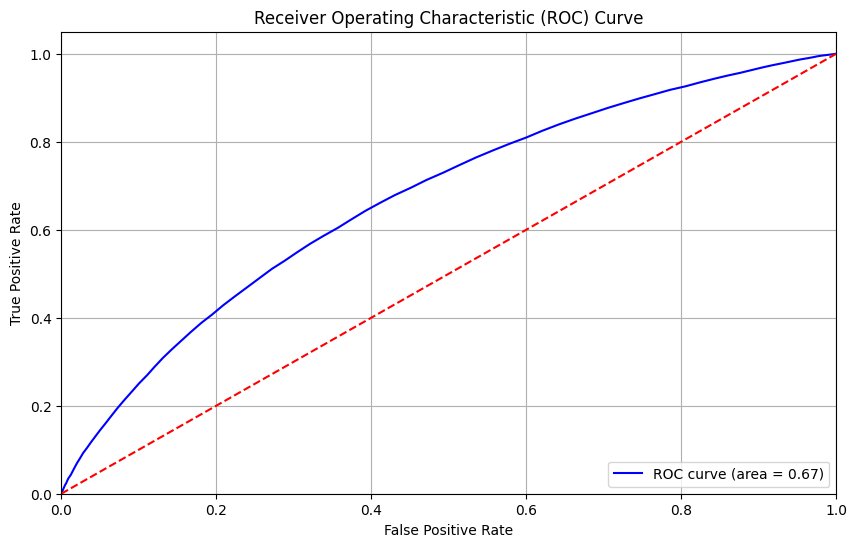

In [191]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt

# Define the features and target variable
X = data[['LR_crypto', 'vol_crypto_rr_10', 'vol_crypto_rr_30', 'trade_count_etf_diff', 'trade_count_etf', 'LR_crypto_rs_10', 'LR_crypto_rs_5', 'LR_crypto_rs_15', 'LR_crypto_rs_20']]
y = np.where(data['LR_etf'].shift() > 0, 1, -1)  # Convert to binary outcome

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, random_state=42)

# Create and fit the random forest classifier model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # Get predicted probabilities for ROC

# Print the classification report
print(classification_report(y_test, y_pred))

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


In [264]:
# Make predictions on the entire dataset
data['Predicted'] = model.predict(data[['LR_crypto', 'vol_crypto_rr_10', 'vol_crypto_rr_30', 'trade_count_etf_diff', 'trade_count_etf', 'LR_crypto_rs_10', 'LR_crypto_rs_5', 'LR_crypto_rs_15', 'LR_crypto_rs_20']])
data['Predicted_Probabilities'] = model.predict_proba(data[['LR_crypto', 'vol_crypto_rr_10', 'vol_crypto_rr_30', 'trade_count_etf_diff', 'trade_count_etf', 'LR_crypto_rs_10', 'LR_crypto_rs_5', 'LR_crypto_rs_15', 'LR_crypto_rs_20']])[:, 1]


/var/folders/c8/c3xvsb_56wq1czrwq0kr796c0000gn/T/ipykernel_17740/4131325370.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['return'] = (s['Predicted'].shift() * s['LR_etf'])


<Axes: >

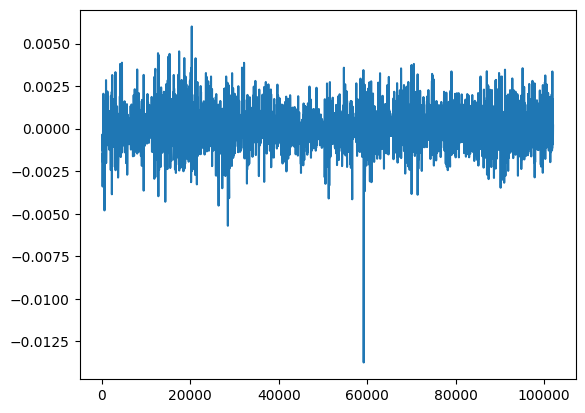

In [262]:
s = data[['LR_etf', 'Predicted', 'Predicted_Probabilities']]
s['return'] = (s['Predicted'].shift() * s['LR_etf'])
s[s['Predicted_Probabilities'] > 0.80]['return'].plot(kind='kde')

In [221]:
data[['vol_crypto_rr_10', 'vol_crypto_rr_30', 'LR_crypto_rs_10', 'LR_crypto_rs_5', 'LR_crypto_rs_15', 'LR_crypto_rs_20', 'Predicted_Probabilities']]

,vol_crypto_rr_10,vol_crypto_rr_30,LR_crypto_rs_10,LR_crypto_rs_5,LR_crypto_rs_15,LR_crypto_rs_20,Predicted_Probabilities
30,4.468450e-03,1.347220e-03,-0.024071,-0.025512,-0.040866,-0.049511,0.55
31,3.164117e-03,1.390430e-03,-0.031110,-0.031830,-0.047550,-0.055319,0.57
32,8.829943e-06,4.233832e-06,-0.031121,-0.028048,-0.043121,-0.057799,0.61
33,8.842386e-06,4.263267e-06,-0.032174,-0.024711,-0.030054,-0.052539,0.60
34,7.218139e-04,4.085956e-04,-0.039163,-0.019041,-0.034666,-0.055540,0.35
...,...,...,...,...,...,...,...
102044,3.868482e-10,2.574881e-10,-0.003627,-0.000933,-0.005671,-0.005962,0.16
102045,1.194892e-08,7.828844e-09,-0.003103,-0.000370,-0.003622,-0.005568,0.41
102046,6.241387e-05,4.121546e-05,-0.002586,0.000760,-0.003029,-0.005753,0.58
102047,6.813586e-08,4.422018e-08,-0.002102,0.000772,-0.003016,-0.005351,0.45


/Users/shromannmajumder/Documents/Algorithimic Trading/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/Users/shromannmajumder/Documents/Algorithimic Trading/.venv/lib/python3.13/site-packages/seaborn/axisgrid.py:1889: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(y=self.y, ax=self.ax_marg_y, **kwargs)


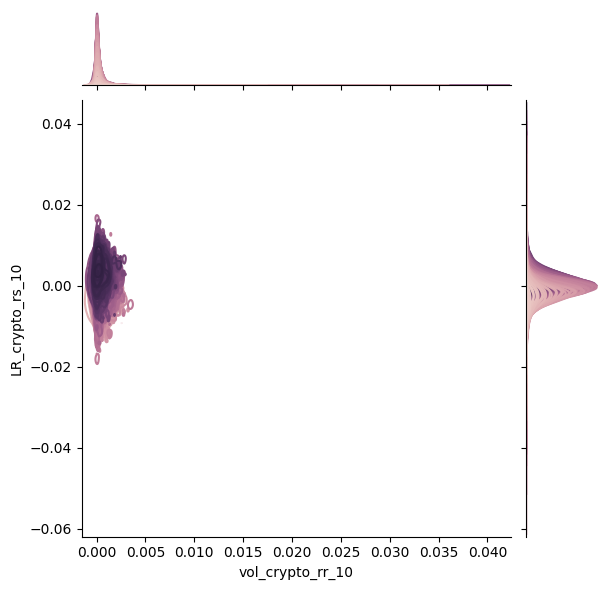

In [247]:
sns.jointplot(data, x='vol_crypto_rr_10', y='LR_crypto_rs_10', hue='Predicted_Probabilities', kind='kde', legend=False)